# Assignment 1 - Track 6

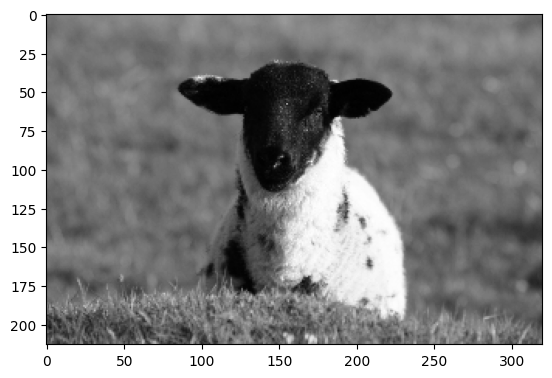

In [1]:
import numpy as np
import pandas as pd
import numba
import matplotlib.pyplot as plt
import cv2

# Path: main.ipynb

img = cv2.imread('./images/1_27_s.bmp', cv2.IMREAD_GRAYSCALE)

# display image
plt.imshow(img, cmap='gray')
plt.show()

### Defining convolution function and LoG generator

Log defined as:
$$ \nabla^2G(x,y) = \frac{1}{\pi\sigma^4} \left[1 - \frac{x^2+y^2}{2\sigma^2}\right] \exp \left\{ -\frac{x^2+y^2}{2\sigma^2}\right\} $$

Convolution function defined as:
$$ C(x,y) = \sum_{i=0}^{k} \sum_{j=0}^{k} I(x+i,y+j)K(i,j) $$
where $I$ is the image, $K$ is the kernel and $k = dim(K)$

Image has been padded with zeros to avoid boundary issues.

In [30]:
def convolve(img, kernel) -> np.ndarray:
    h, w = img.shape
    kh, kw = kernel.shape
    conv = np.zeros((h, w))

    # some padding
    img = np.pad(img, (kh//2, kw//2), 'constant')

    # separate function for numba
    #@numba.jit(nopython=True)
    def process(img, h, w, kh, kw, conv):
        # iterate over image
        for x in range(h):
            for y in range(w):
                # of course using compact numpy notation instead of explicit loops for sum
                conv[x, y] = (kernel * img[x: x+kh, y: y+kw]).sum()
        return conv

    return process(img, h, w, kh, kw, conv)

def log(i, j, sigma):
    return (-1)/(np.pi * sigma**4) * (1 - (i**2 + j**2)/(2*sigma**2)) * np.exp(-(i**2+j**2)/(2*sigma**2))

def laplacian_of_gaussian(dim, sigma=1, k=1):
    kernel = np.zeros((dim, dim)) 
    for i in range(-dim//2, dim//2+1):
        for j in range(-dim//2, dim//2+1):
            kernel[i+dim//2, j+dim//2] = log(i, j, sigma)

    return sigma**2 * kernel

## First try: test kernel generation and convolution implementation

### Kernel plot

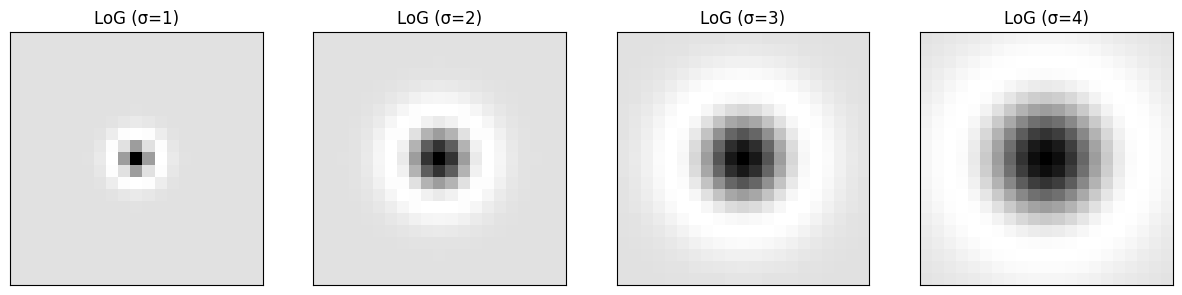

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for i, sigma in enumerate([1, 2, 3, 4]):
    kernel = laplacian_of_gaussian(21, sigma)
    axs[i].imshow(kernel, cmap='gray')
    axs[i].set_title(f'LoG (σ={sigma})')
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Generated kernels actually are LoGs. Now, test convolution on the normalized image, with sigma = 2 and kernel size = 21

### Convolution test

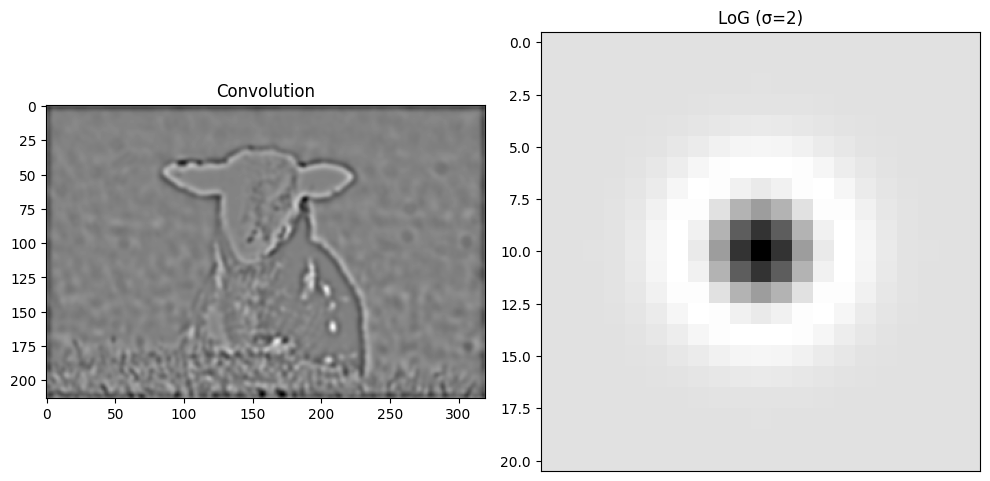

In [24]:
kernel = laplacian_of_gaussian(21, 2)
fig, axs = plt.subplots(1,2, figsize=(10, 5))

# normalizing image to [0, 1]
axs[0].imshow(convolve(img/255, kernel), cmap='gray')

axs[0].set_title('Convolution')
axs[1].imshow(kernel, cmap='gray')
axs[1].set_title('LoG (σ=2)')
axs[1].set_xticks([])
fig.tight_layout()

It works as expected, since LoG is basically an edge detector.

### Comparison of my convolution with openCV.filter2D. 
 Note: openCV.filter2D actually computes correlation, not convolution.

Text(0.5, 1.0, 'OpenCV')

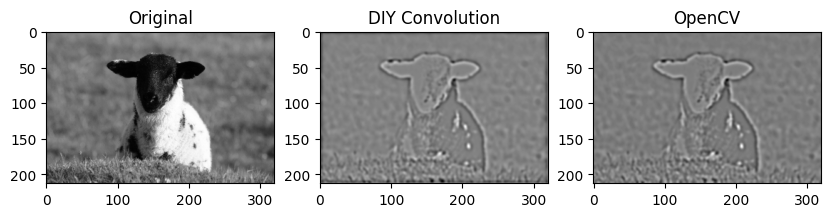

In [27]:
filtered = convolve(img/255, kernel)
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(img/255, cmap='gray')
axs[1].imshow(filtered, cmap='gray')
axs[2].imshow(cv2.filter2D(img/255, -1, kernel), cmap='gray')

axs[0].set_title('Original')
axs[1].set_title('DIY Convolution')
axs[2].set_title('OpenCV')

### Now, let's see what happens changing sigma scale.

I will test sigma from 1 to 3, with 0.1 step.
Kernel size will be 21 as usual. I found this to be a good tradeoff between accuracy and computation time.

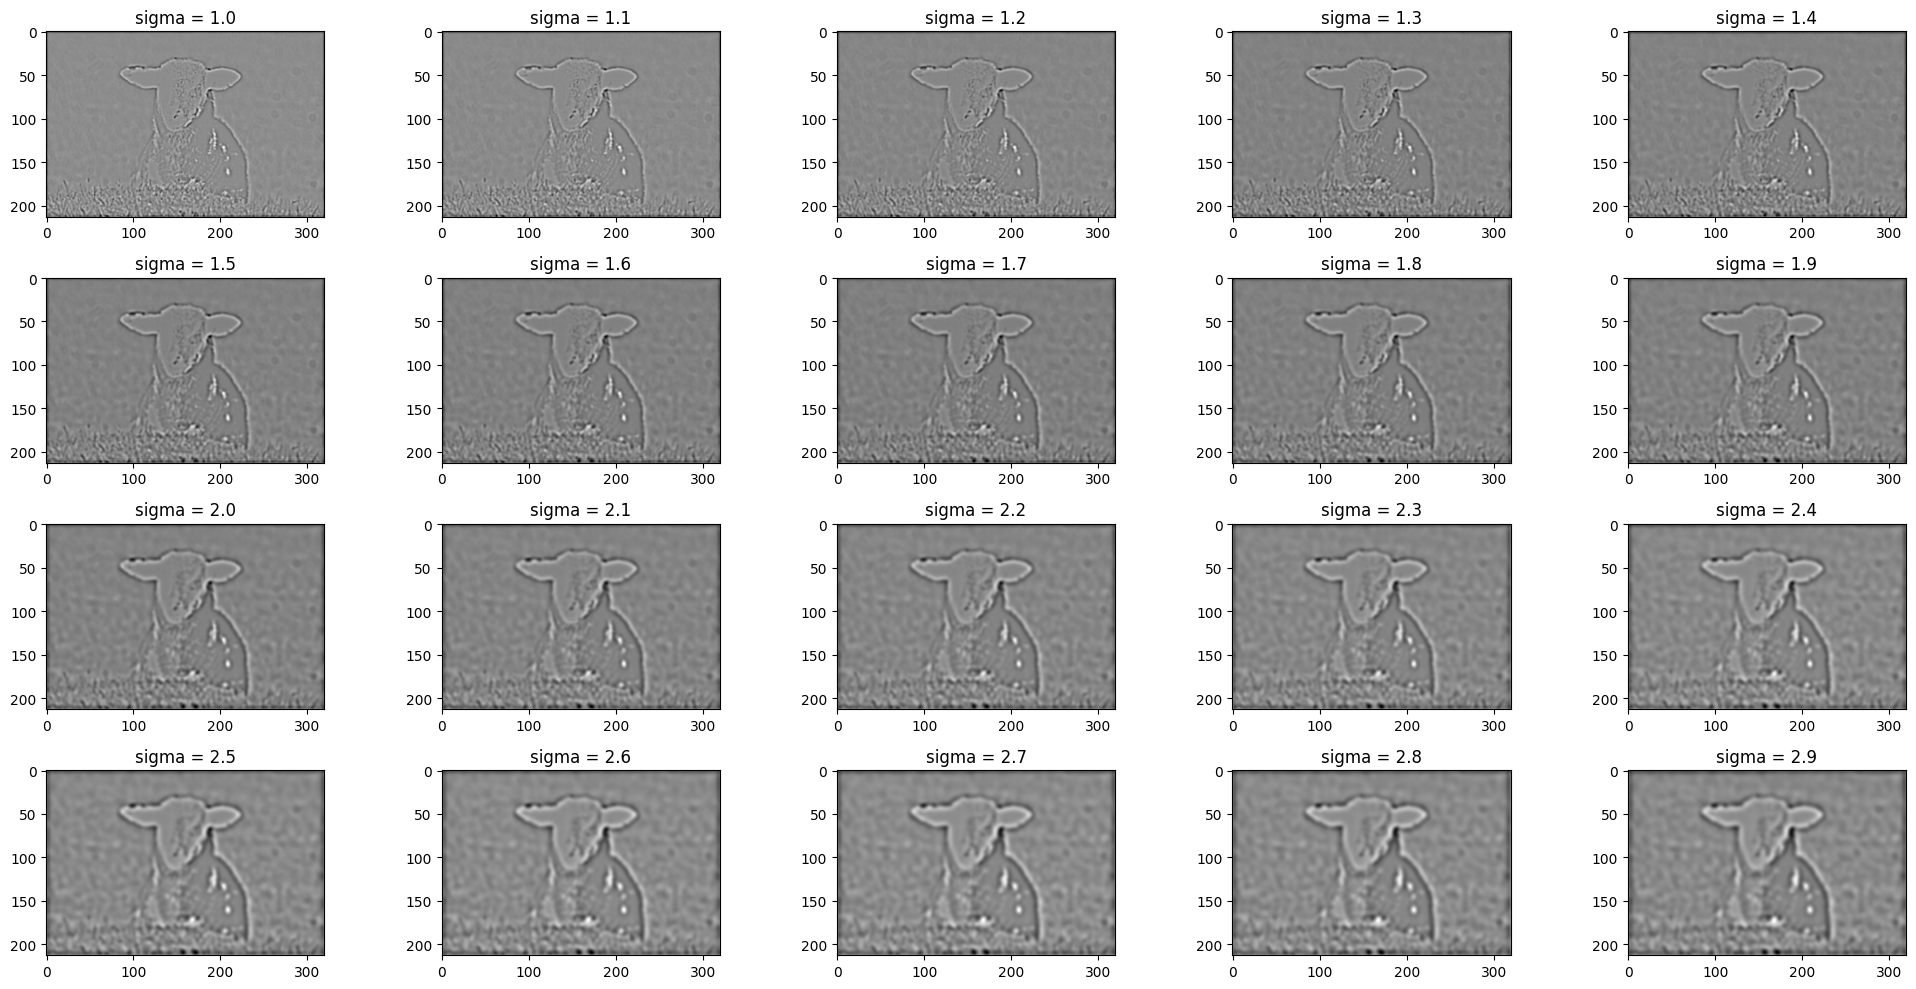

In [28]:
# try 10 values of sigma and plot it in range 1.5 to 2.5 with step 0.1
sigmas = np.arange(1, 3, 0.1)
fig, axs = plt.subplots(4, 5, figsize=(20, 10))
for i, sigma in enumerate(sigmas):
    kernel = laplacian_of_gaussian(21, sigma)
    filtered = convolve(img/255, kernel)
    axs[i//5, i%5].imshow(filtered, cmap='gray')
    axs[i//5, i%5].set_title(f'sigma = {round(sigma,2)}')
fig.tight_layout()

### Results:
Sigma scaling seem working as expected. The more sigma increases, the more the image is blurred.

In [65]:
def detect_blobs(img, threshold=1, sigma_start=1, sigma_end=4, sigma_step=1, kernel_size=11, stride=3, normalize=False):

    if normalize:
        img = img/np.max(img)

    scales = np.arange(sigma_start, sigma_end, sigma_step)
    kernels = [laplacian_of_gaussian(kernel_size, s) for s in scales]

    height, width = img.shape

    filtered = [convolve(img, kernel) for kernel in kernels]
    filtered = [np.pad(i, (stride+1, stride+1), 'constant') for i in filtered]
    filtered = np.array(filtered)
    blob_cords = []
   
    for x in range(1, height, stride):
        for y in range(1, width, stride):

            region = filtered[:, x:x+stride, y:y+stride]
            candidate_max = np.amax(region)
            level, h, w = np.unravel_index(np.argmax(region), region.shape)
            if candidate_max > threshold:
                blob_cords.append((1.414*(scales[level]), x+h, y+w))
                
    return set(blob_cords)

In [71]:
np.arange(1, 4, 1)

array([1, 2, 3])

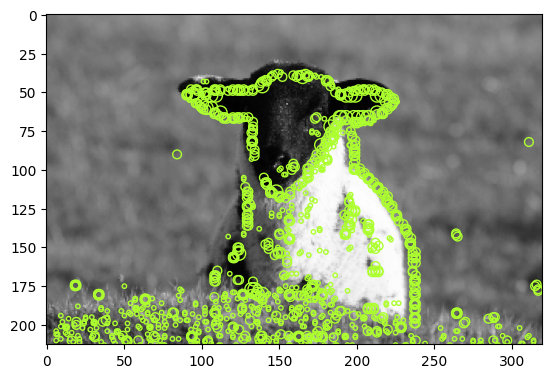

In [72]:
blobs = detect_blobs(
    img, 
    threshold=0.05, 
    sigma_start=1, 
    sigma_end=4, 
    sigma_step=1, 
    kernel_size=15, 
    stride=3, 
    normalize=True
)

plt.imshow(img, cmap='gray')
for blob in blobs:
    circle = plt.Circle((blob[2], blob[1]), blob[0], color='greenyellow', fill=False, linewidth=1)
    plt.gca().add_patch(circle)

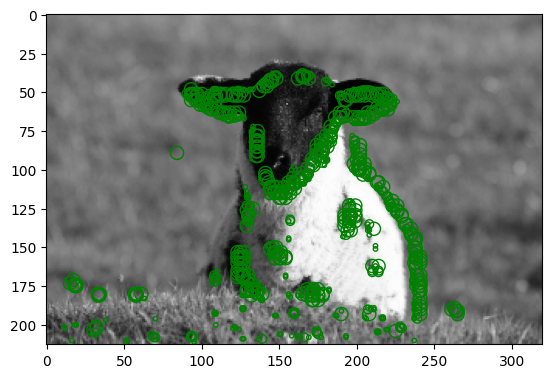

In [22]:
blobs = detect_blobs(img, threshold=20)

plt.imshow(img, cmap='gray')
for blob in blobs:
    circle = plt.Circle((blob[2], blob[1]), blob[0]*1.414, color='g', fill=False)
    plt.gca().add_patch(circle)
